<center><h1>Najam 9661 Quiz 3</h1></center> 

In [28]:
from pyspark.sql import SparkSession

In [29]:
spark = SparkSession.builder.appName("ml-quiz").getOrCreate()

In [30]:
df = spark.read.csv("./data/placement.csv",inferSchema=True, header = True)

In [31]:
df.printSchema()

root
 |-- cgpa: double (nullable = true)
 |-- placement_exam_marks: double (nullable = true)
 |-- placed: integer (nullable = true)



In [32]:
print((df.count(), len(df.columns)))

(1000, 3)


In [33]:
df.filter(df.placed==0).count()

511

In [34]:
from pyspark.sql.functions import isnull, when, count, col
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+----+--------------------+------+
|cgpa|placement_exam_marks|placed|
+----+--------------------+------+
|   0|                   0|     0|
+----+--------------------+------+



In [35]:
import seaborn as sns

<AxesSubplot:>

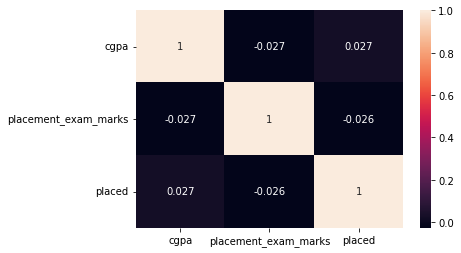

In [36]:
sns.heatmap(df.toPandas().corr(), annot = True)

In [37]:
x = df.drop('placed')
x.show()

+----+--------------------+
|cgpa|placement_exam_marks|
+----+--------------------+
|7.19|                26.0|
|7.46|                38.0|
|7.54|                40.0|
|6.42|                 8.0|
|7.23|                17.0|
| 7.3|                23.0|
|6.69|                11.0|
|7.12|                39.0|
|6.45|                38.0|
|7.75|                94.0|
|6.82|                16.0|
|6.38|                 7.0|
|6.58|                16.0|
|5.68|                26.0|
|7.91|                43.0|
| 7.1|                21.0|
|6.53|                19.0|
|7.56|                22.0|
|6.93|                27.0|
|7.63|                29.0|
+----+--------------------+
only showing top 20 rows



In [38]:
from pyspark.ml.feature import VectorAssembler

In [39]:
assembler = VectorAssembler(inputCols=x.columns, outputCol='features')
transformed_data = assembler.transform(df)
transformed_data.show(truncate=False)

+----+--------------------+------+-----------+
|cgpa|placement_exam_marks|placed|features   |
+----+--------------------+------+-----------+
|7.19|26.0                |1     |[7.19,26.0]|
|7.46|38.0                |1     |[7.46,38.0]|
|7.54|40.0                |1     |[7.54,40.0]|
|6.42|8.0                 |1     |[6.42,8.0] |
|7.23|17.0                |0     |[7.23,17.0]|
|7.3 |23.0                |1     |[7.3,23.0] |
|6.69|11.0                |0     |[6.69,11.0]|
|7.12|39.0                |1     |[7.12,39.0]|
|6.45|38.0                |0     |[6.45,38.0]|
|7.75|94.0                |1     |[7.75,94.0]|
|6.82|16.0                |1     |[6.82,16.0]|
|6.38|7.0                 |1     |[6.38,7.0] |
|6.58|16.0                |1     |[6.58,16.0]|
|5.68|26.0                |0     |[5.68,26.0]|
|7.91|43.0                |0     |[7.91,43.0]|
|7.1 |21.0                |0     |[7.1,21.0] |
|6.53|19.0                |0     |[6.53,19.0]|
|7.56|22.0                |1     |[7.56,22.0]|
|6.93|27.0   

In [40]:
#split the data
(x_train,x_test) = transformed_data.randomSplit([0.8,0.2])

<center><h1>Decision Tree Classifier</h1></center>

In [41]:
from pyspark.ml.classification import DecisionTreeClassifier
clf = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'placed', maxDepth = 3 )

In [42]:
model = clf.fit(x_train)

In [43]:
predictions = model.transform(x_test)
predictions.select('cgpa', 'placement_exam_marks', 'placed','prediction').show()

+----+--------------------+------+----------+
|cgpa|placement_exam_marks|placed|prediction|
+----+--------------------+------+----------+
| 4.9|                10.0|     1|       1.0|
|5.48|                18.0|     0|       1.0|
|5.56|                10.0|     0|       1.0|
|5.56|                50.0|     0|       0.0|
|5.58|                41.0|     0|       0.0|
|5.64|                37.0|     1|       0.0|
|5.66|                57.0|     1|       0.0|
|5.72|                47.0|     0|       0.0|
|5.74|                50.0|     0|       0.0|
|5.91|                11.0|     1|       1.0|
|5.91|                27.0|     0|       1.0|
|5.94|                10.0|     0|       1.0|
|5.95|               100.0|     0|       0.0|
| 6.0|                33.0|     1|       0.0|
|6.01|                 9.0|     0|       1.0|
|6.05|                45.0|     1|       0.0|
|6.07|                29.0|     1|       0.0|
| 6.1|                 9.0|     0|       1.0|
|6.12|                17.0|     0|

In [44]:
predictions.groupBy('placed', 'prediction').count().show()

+------+----------+-----+
|placed|prediction|count|
+------+----------+-----+
|     1|       0.0|   61|
|     0|       0.0|   46|
|     1|       1.0|   46|
|     0|       1.0|   56|
+------+----------+-----+



In [48]:
# calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND placed = prediction').count()
TP = predictions.filter('prediction = 1 AND placed = prediction').count()
FN = predictions.filter('prediction = 0 AND placed <> prediction').count()
FP = predictions.filter('prediction = 1 AND placed <> prediction').count()

In [51]:
accuracy_DecisionTree = (TN + TP) / (TN + TP + FN +FP)
precision_DecisionTree = TP / (TP + FP)
recall_DecisionTree = TP/ (TP + FN)

print('n accuracy: %0.3f' % accuracy_DecisionTree)
print('n precision: %0.3f' % precision_DecisionTree)
print('n recall: %0.3f' % recall_DecisionTree)

n accuracy: 0.440
n precision: 0.451
n recall: 0.430


<center><h1>Logistic Regression Classifier</h1></center>

In [55]:
from pyspark.ml.classification import LogisticRegression
clf = LogisticRegression(featuresCol = 'features', labelCol = 'placed', maxIter = 10 )

In [56]:
model = clf.fit(x_train)

In [57]:
predictions = model.transform(x_test)
predictions.select('cgpa', 'placement_exam_marks', 'placed','prediction').show()

+----+--------------------+------+----------+
|cgpa|placement_exam_marks|placed|prediction|
+----+--------------------+------+----------+
| 4.9|                10.0|     1|       0.0|
|5.48|                18.0|     0|       0.0|
|5.56|                10.0|     0|       0.0|
|5.56|                50.0|     0|       0.0|
|5.58|                41.0|     0|       0.0|
|5.64|                37.0|     1|       0.0|
|5.66|                57.0|     1|       0.0|
|5.72|                47.0|     0|       0.0|
|5.74|                50.0|     0|       0.0|
|5.91|                11.0|     1|       0.0|
|5.91|                27.0|     0|       0.0|
|5.94|                10.0|     0|       0.0|
|5.95|               100.0|     0|       0.0|
| 6.0|                33.0|     1|       0.0|
|6.01|                 9.0|     0|       0.0|
|6.05|                45.0|     1|       0.0|
|6.07|                29.0|     1|       0.0|
| 6.1|                 9.0|     0|       0.0|
|6.12|                17.0|     0|

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "e:\Course\BigData\Quiz\quizenv\lib\site-packages\pyspark\ml\wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeClassifier' object has no attribute '_java_obj'


In [58]:
predictions.groupBy('placed', 'prediction').count().show()

+------+----------+-----+
|placed|prediction|count|
+------+----------+-----+
|     1|       0.0|   85|
|     0|       0.0|   86|
|     1|       1.0|   22|
|     0|       1.0|   16|
+------+----------+-----+



In [59]:
# calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND placed = prediction').count()
TP = predictions.filter('prediction = 1 AND placed = prediction').count()
FN = predictions.filter('prediction = 0 AND placed <> prediction').count()
FP = predictions.filter('prediction = 1 AND placed <> prediction').count()

In [60]:
accuracy_LogisticRegression = (TN + TP) / (TN + TP + FN +FP)
precision_LogisticRegression = TP / (TP + FP)
recall_LogisticRegression = TP/ (TP + FN)

print('n accuracy: %0.3f' % accuracy_LogisticRegression)
print('n precision: %0.3f' % precision_LogisticRegression)
print('n recall: %0.3f' % recall_LogisticRegression)

n accuracy: 0.517
n precision: 0.579
n recall: 0.206


<center><h1>Random Forest Classifier</h1></center>

In [61]:
from pyspark.ml.classification import RandomForestClassifier
clf = RandomForestClassifier(featuresCol = 'features', labelCol = 'placed', maxDepth = 5 )

In [62]:
model = clf.fit(x_train)

In [63]:
predictions = model.transform(x_test)
predictions.select('cgpa', 'placement_exam_marks', 'placed','prediction').show()

+----+--------------------+------+----------+
|cgpa|placement_exam_marks|placed|prediction|
+----+--------------------+------+----------+
| 4.9|                10.0|     1|       0.0|
|5.48|                18.0|     0|       1.0|
|5.56|                10.0|     0|       0.0|
|5.56|                50.0|     0|       1.0|
|5.58|                41.0|     0|       1.0|
|5.64|                37.0|     1|       1.0|
|5.66|                57.0|     1|       0.0|
|5.72|                47.0|     0|       1.0|
|5.74|                50.0|     0|       1.0|
|5.91|                11.0|     1|       1.0|
|5.91|                27.0|     0|       0.0|
|5.94|                10.0|     0|       0.0|
|5.95|               100.0|     0|       1.0|
| 6.0|                33.0|     1|       0.0|
|6.01|                 9.0|     0|       0.0|
|6.05|                45.0|     1|       1.0|
|6.07|                29.0|     1|       0.0|
| 6.1|                 9.0|     0|       1.0|
|6.12|                17.0|     0|

In [64]:
predictions.groupBy('placed', 'prediction').count().show()

+------+----------+-----+
|placed|prediction|count|
+------+----------+-----+
|     1|       0.0|   63|
|     0|       0.0|   62|
|     1|       1.0|   44|
|     0|       1.0|   40|
+------+----------+-----+



In [65]:
# calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND placed = prediction').count()
TP = predictions.filter('prediction = 1 AND placed = prediction').count()
FN = predictions.filter('prediction = 0 AND placed <> prediction').count()
FP = predictions.filter('prediction = 1 AND placed <> prediction').count()

In [66]:
accuracy_RandomForestClassifier = (TN + TP) / (TN + TP + FN +FP)
precision_RandomForestClassifier = TP / (TP + FP)
recall_RandomForestClassifier = TP/ (TP + FN)

print('n accuracy: %0.3f' % accuracy_RandomForestClassifier)
print('n precision: %0.3f' % precision_RandomForestClassifier)
print('n recall: %0.3f' % recall_RandomForestClassifier)

n accuracy: 0.507
n precision: 0.524
n recall: 0.411


<center><h1>Comparision</h1></center>

In [67]:
print("LogisticRegression")
print('n accuracy: %0.3f' % accuracy_LogisticRegression)
print('n precision: %0.3f' % precision_LogisticRegression)
print('n recall: %0.3f' % recall_LogisticRegression)
print('------------------------------------')
print("DecisionTree")
print('n accuracy: %0.3f' % accuracy_DecisionTree)
print('n precision: %0.3f' % precision_DecisionTree)
print('n recall: %0.3f' % recall_DecisionTree)
print('------------------------------------')
print("RandomForest")
print('n accuracy: %0.3f' % accuracy_RandomForestClassifier)
print('n precision: %0.3f' % precision_RandomForestClassifier)
print('n recall: %0.3f' % recall_RandomForestClassifier)

LogisticRegression
n accuracy: 0.517
n precision: 0.579
n recall: 0.206
------------------------------------
DecisionTree
n accuracy: 0.440
n precision: 0.451
n recall: 0.430
------------------------------------
RandomForest
n accuracy: 0.507
n precision: 0.524
n recall: 0.411
